# 라이브러리 불러오기

In [38]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 랜덤 시드 설정

In [39]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# 데이터 불러오기

In [40]:
train_data = pd.read_csv('../data/train.csv')
test_data = pd.read_csv('../data/test.csv')
sample_submission = pd.read_csv('../data/sample_submission.csv')
interestRate = pd.read_csv('../data/interestRate.csv')

In [41]:
train_data['type'] = "train"
test_data['type'] = "test"
df = pd.concat([train_data, test_data], axis = 0)
df.drop(['index'], axis = 1, inplace = True)
df = df.merge(interestRate, left_on='contract_year_month', right_on='year_month', how='left')
df.drop(columns=['year_month'], inplace=True)

In [42]:
def train_valid_test_split(df):
    # 데이터 분할
    train_data = df[df['type'] == 'train']
    test_data = df[df['type'] == 'test']

    valid_start = 202307
    valid_end = 202312

    valid_data = train_data[(train_data['contract_year_month'] >= valid_start) & (train_data['contract_year_month'] <= valid_end)]
    train_data = train_data[~((train_data['contract_year_month'] >= valid_start) & (train_data['contract_year_month'] <= valid_end))]

    return train_data, valid_data, test_data

In [43]:
train_data, valid_data, test_data = train_valid_test_split(df)

In [44]:
from sklearn.cluster import KMeans

def create_cluster_density(train_data: pd.DataFrame, valid_data: pd.DataFrame, test_data: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    # 클러스터별 밀도 계산 (클러스터별 포인트 수)
    cluster_density = train_data.groupby('cluster').size().reset_index(name='density')

    train_data = train_data.merge(cluster_density, on='cluster', how='left')
    valid_data = valid_data.merge(cluster_density, on='cluster', how='left')
    test_data = test_data.merge(cluster_density, on='cluster', how='left')

    return train_data, valid_data, test_data

def create_cluster_distance_to_centroid(data: pd.DataFrame, centroids) -> pd.DataFrame:
    # 포함되는 군집의 centroid와의 거리 계산
    lat_centroids = np.array([centroids[cluster, 0] for cluster in data['cluster']])
    lon_centroids = np.array([centroids[cluster, 1] for cluster in data['cluster']])
    lat_diff = data['latitude'].values - lat_centroids
    lon_diff = data['longitude'].values - lon_centroids
    data['distance_to_centroid'] = np.sqrt(lat_diff ** 2 + lon_diff ** 2)
    return data

def create_clustering_target(train_data: pd.DataFrame, valid_data: pd.DataFrame, test_data: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    # K-means 클러스터링
    k = 20
    kmeans = KMeans(n_clusters=k, random_state=42)
    train_data['cluster'] = kmeans.fit_predict(train_data[['latitude', 'longitude']])
    valid_data['cluster'] = kmeans.predict(valid_data[['latitude', 'longitude']])
    test_data['cluster'] = kmeans.predict(test_data[['latitude', 'longitude']])
    
    train_data['cluster'] = train_data['cluster'].astype('category')
    valid_data['cluster'] = valid_data['cluster'].astype('category')
    test_data['cluster'] = test_data['cluster'].astype('category')

    # 군집 밀도 변수 추가
    train_data, valid_data, test_data = create_cluster_density(train_data, valid_data, test_data)

    centroids = kmeans.cluster_centers_

    # 군집 centroid까지의 거리 변수 추가
    train_data = create_cluster_distance_to_centroid(train_data, centroids)
    valid_data = create_cluster_distance_to_centroid(valid_data, centroids)
    test_data = create_cluster_distance_to_centroid(test_data, centroids)

    return train_data, valid_data, test_data

In [45]:
train_data, valid_data, test_data = create_clustering_target(train_data, valid_data, test_data)

/tmp/ipykernel_463827/12689278.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['cluster'] = kmeans.predict(test_data[['latitude', 'longitude']])
/tmp/ipykernel_463827/12689278.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['cluster'] = test_data['cluster'].astype('category')
/tmp/ipykernel_463827/12689278.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or 

In [ ]:
def plot_clusters(data, title):
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(data['latitude'], data['longitude'], c=data['cluster'], cmap='viridis', alpha=0.6)
    plt.title(title)
    plt.colorbar(scatter, label='Cluster')
    plt.grid(True)
    plt.show()

# 3. Train, Valid, Test 데이터의 클러스터링 결과 시각화
plot_clusters(train_data, 'Train Data Clusters')
plot_clusters(valid_data, 'Valid Data Clusters')
plot_clusters(test_data, 'Test Data Clusters')

In [ ]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# 클러스터 수에 따른 SSE 계산
sse = []
cluster_range = range(1, 50)  # 1부터 30까지의 클러스터 수

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=RANDOM_SEED)
    kmeans.fit(train_data[['latitude', 'longitude']])  # 클러스터링할 피처 선택
    sse.append(kmeans.inertia_)

# 엘보우 그래프 그리기
plt.figure(figsize=(10, 6))
plt.plot(cluster_range, sse, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')
plt.xticks(cluster_range)
plt.grid()
plt.show()

In [46]:
import pandas as pd
from sklearn.neighbors import KDTree

subwayInfo = pd.read_csv("../data/subwayInfo.csv")

# KD-트리 생성
subway_coords = subwayInfo[['latitude', 'longitude']].values
tree = KDTree(subway_coords, leaf_size=10)

# 거리 계산 함수 정의
def add_nearest_subway_distance(data):
    # 각 집의 좌표 가져오기
    house_coords = data[['latitude', 'longitude']].values
    # 가장 가까운 지하철 역까지의 거리 계산
    distances, indices = tree.query(house_coords, k=1)  # k=1: 가장 가까운 역
    # 거리를 데이터프레임에 추가 (미터 단위로 변환)
    data['nearest_subway_distance'] = distances.flatten()
    return data

# 각 데이터셋에 대해 거리 추가
train_data = add_nearest_subway_distance(train_data)
valid_data = add_nearest_subway_distance(valid_data)
test_data = add_nearest_subway_distance(test_data)

# 결과 확인
print(train_data.head())
print(valid_data.head())
print(test_data.head())

   area_m2  contract_year_month  contract_day  contract_type  floor  \
0  84.9981               201906            25              2      9   
1  84.9981               202003            26              2     20   
2  84.9981               202003            28              2      8   
3  59.3400               201907            15              2      1   
4  59.8100               201904            12              2      6   

   built_year   latitude   longitude  age  deposit   type  interest_rate  \
0        2019  37.054314  127.045216    0  17000.0  train           1.78   
1        2019  37.054314  127.045216    1  23000.0  train           1.26   
2        2019  37.054314  127.045216    1  23000.0  train           1.26   
3        1986  36.964647  127.055847   33   5000.0  train           1.68   
4        1995  36.972390  127.084514   24   1800.0  train           1.85   

  cluster  density  distance_to_centroid  nearest_subway_distance  
0       0    52950              0.026283        

In [47]:
import pandas as pd
from sklearn.neighbors import KDTree

# subwayInfo에는 지하철 역의 위도와 경도가 포함되어 있다고 가정
subwayInfo = pd.read_csv("../data/subwayInfo.csv")
subway_coords = subwayInfo[['latitude', 'longitude']].values
tree = KDTree(subway_coords, leaf_size=10)

def count_subways_within_radius(data, radius):
    counts = []  # 초기화
    # 10,000개씩 배치로 처리
    for i in range(0, len(data), 10000):
        batch = data.iloc[i:i+10000]
        house_coords = batch[['latitude', 'longitude']].values
        # KDTree를 사용하여 주어진 반경 내 지하철역 찾기
        indices = tree.query_radius(house_coords, r=radius)  # 반경에 대한 인덱스
        # 각 집의 주변 지하철역 개수 세기
        counts.extend(len(idx) for idx in indices)

    # counts의 길이가 data와 동일해야 함
    # counts가 데이터프레임 크기보다 작을 경우 0으로 채우기
    if len(counts) < len(data):
        counts.extend([0] * (len(data) - len(counts)))
    
    # 데이터프레임에 결과 추가
    data['subways_within_radius'] = counts
    return data

# 각 데이터셋에 대해 거리 추가 (예: 반경 100미터)
radius = 0.01  # 약 1km
train_data = count_subways_within_radius(train_data, radius)
valid_data = count_subways_within_radius(valid_data, radius)
test_data = count_subways_within_radius(test_data, radius)

# 결과 확인
print(train_data[['latitude', 'longitude', 'subways_within_radius']].head())
print(valid_data[['latitude', 'longitude', 'subways_within_radius']].head())
print(test_data[['latitude', 'longitude', 'subways_within_radius']].head())


    latitude   longitude  subways_within_radius
0  37.054314  127.045216                      1
1  37.054314  127.045216                      1
2  37.054314  127.045216                      1
3  36.964647  127.055847                      0
4  36.972390  127.084514                      0
    latitude   longitude  subways_within_radius
0  37.200075  126.820401                      0
1  37.200075  126.820401                      0
2  37.200075  126.820401                      0
3  37.200075  126.820401                      0
4  37.200075  126.820401                      0
    latitude   longitude  subways_within_radius
0  36.965423  127.048779                      0
1  36.963105  127.040678                      0
2  36.957089  127.047449                      0
3  36.957089  127.047449                      0
4  36.957089  127.047449                      0


In [48]:
from sklearn.neighbors import KDTree

def create_nearest_park_distance(train_data: pd.DataFrame, valid_data: pd.DataFrame, test_data: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    park_data = pd.read_csv("../data/parkInfo.csv")

    seoul_area_parks = park_data[(park_data['latitude'] >= 37.0) & (park_data['latitude'] <= 38.0) &
                                (park_data['longitude'] >= 126.0) & (park_data['longitude'] <= 128.0)]

    # 수도권 공원의 좌표로 KDTree 생성
    park_coords = seoul_area_parks[['latitude', 'longitude']].values
    park_tree = KDTree(park_coords, leaf_size=10)

    def add_nearest_park_features(data):
        # 각 집의 좌표로 가장 가까운 공원 찾기
        house_coords = data[['latitude', 'longitude']].values
        distances, indices = park_tree.query(house_coords, k=1)  # 가장 가까운 공원 찾기

        # 가장 가까운 공원까지의 거리 추가
        nearest_park_distances = distances.flatten()

        data['nearest_park_distance'] = nearest_park_distances
        return data

    # train, valid, test 데이터에 가장 가까운 공원 거리 및 면적 추가
    train_data = add_nearest_park_features(train_data)
    valid_data = add_nearest_park_features(valid_data)
    test_data = add_nearest_park_features(test_data)

    return train_data, valid_data, test_data

def create_school_within_radius(train_data: pd.DataFrame, valid_data: pd.DataFrame, test_data: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    school_info = pd.read_csv("../data/schoolinfo.csv")
    seoul_area_school = school_info[(school_info['latitude'] >= 37.0) & (school_info['latitude'] <= 38.0) &
                                (school_info['longitude'] >= 126.0) & (school_info['longitude'] <= 128.0)]
    school_coords = seoul_area_school[['latitude', 'longitude']].values
    tree = KDTree(school_coords, leaf_size=10)

    def count_schools_within_radius(data, radius):
        counts = []  # 학교 개수를 저장할 리스트 초기화
        for i in range(0, len(data), 10000):  # 10,000개씩 배치로 처리
            batch = data.iloc[i:i + 10000]
            house_coords = batch[['latitude', 'longitude']].values
            indices = tree.query_radius(house_coords, r=radius)  # 반경 내의 인덱스 찾기
            counts.extend(len(idx) for idx in indices)  # 각 배치의 학교 개수 추가
        data['schools_within_radius'] = counts  # 데이터에 추가
        return data
    
    radius = 0.02 # 약 2km
    train_data = count_schools_within_radius(train_data, radius)
    valid_data = count_schools_within_radius(valid_data, radius)
    test_data = count_schools_within_radius(test_data, radius)

    return train_data, valid_data, test_data

def create_sum_park_area_within_radius(train_data: pd.DataFrame, valid_data: pd.DataFrame, test_data: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    park_data = pd.read_csv("../data/parkInfo.csv")

    # 수도권 공원의 좌표 필터링
    seoul_area_parks = park_data[(park_data['latitude'] >= 37.0) & (park_data['latitude'] <= 38.0) &
                                  (park_data['longitude'] >= 126.0) & (park_data['longitude'] <= 128.0)]

    # 수도권 공원의 좌표로 KDTree 생성
    park_coords = seoul_area_parks[['latitude', 'longitude']].values
    park_tree = KDTree(park_coords, leaf_size=10)

    def sum_park_area_within_radius(data, radius=0.02):
        area_sums = []  # 공원 면적 합을 저장할 리스트 초기화
        for i in range(0, len(data), 10000):  # 10,000개씩 배치로 처리
            batch = data.iloc[i:i + 10000]
            house_coords = batch[['latitude', 'longitude']].values
            indices = park_tree.query_radius(house_coords, r=radius)  # 반경 내의 인덱스 찾기
            
            # 각 집에 대해 반경 2km 이내의 공원 면적의 합을 계산
            for idx in indices:
                if idx.size > 0:  # 2km 이내에 공원이 있을 경우
                    areas_sum = seoul_area_parks.iloc[idx]['area'].sum()
                else:
                    areas_sum = 0  # 공원이 없는 경우 면적 0
                area_sums.append(areas_sum)  # 면적 합 추가

        # 결과 추가
        data['nearest_park_area_sum'] = area_sums
        return data

    # train, valid, test 데이터에 반경 1km 이내의 공원 면적 합 추가
    train_data = sum_park_area_within_radius(train_data)
    valid_data = sum_park_area_within_radius(valid_data)
    test_data = sum_park_area_within_radius(test_data)

    return train_data, valid_data, test_data

In [31]:
import pandas as pd
from sklearn.neighbors import KDTree

def create_school_counts_within_radius_by_school_level(train_data: pd.DataFrame, valid_data: pd.DataFrame, test_data: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    school_info = pd.read_csv("../data/schoolinfo.csv")
    seoul_area_school = school_info[(school_info['latitude'] >= 37.0) & (school_info['latitude'] <= 38.0) &
                                     (school_info['longitude'] >= 126.0) & (school_info['longitude'] <= 128.0)]
    
    # 초, 중, 고등학교의 좌표를 분리
    elementary_schools = seoul_area_school[seoul_area_school['schoolLevel'] == 'elementary']
    middle_schools = seoul_area_school[seoul_area_school['schoolLevel'] == 'middle']
    high_schools = seoul_area_school[seoul_area_school['schoolLevel'] == 'high']

    # 각 학교 유형의 좌표로 KDTree 생성
    elementary_coords = elementary_schools[['latitude', 'longitude']].values
    middle_coords = middle_schools[['latitude', 'longitude']].values
    high_coords = high_schools[['latitude', 'longitude']].values

    tree_elementary = KDTree(elementary_coords, leaf_size=10)
    tree_middle = KDTree(middle_coords, leaf_size=10)
    tree_high = KDTree(high_coords, leaf_size=10)

    def count_schools_within_radius(data, radius):
        counts_elementary = []  # 초등학교 개수를 저장할 리스트 초기화
        counts_middle = []      # 중학교 개수를 저장할 리스트 초기화
        counts_high = []        # 고등학교 개수를 저장할 리스트 초기화

        for i in range(0, len(data), 10000):  # 10,000개씩 배치로 처리
            batch = data.iloc[i:i + 10000]
            house_coords = batch[['latitude', 'longitude']].values
            
            # 각 학교 유형의 개수 세기
            indices_elementary = tree_elementary.query_radius(house_coords, r=radius)
            indices_middle = tree_middle.query_radius(house_coords, r=radius)
            indices_high = tree_high.query_radius(house_coords, r=radius)
            
            counts_elementary.extend(len(idx) for idx in indices_elementary)  # 각 배치의 초등학교 개수 추가
            counts_middle.extend(len(idx) for idx in indices_middle)        # 각 배치의 중학교 개수 추가
            counts_high.extend(len(idx) for idx in indices_high)            # 각 배치의 고등학교 개수 추가

        # 데이터에 추가
        data['elementary_schools_within_radius'] = counts_elementary
        data['middle_schools_within_radius'] = counts_middle
        data['high_schools_within_radius'] = counts_high
        
        return data

    radius = 0.02  # 약 2km
    train_data = count_schools_within_radius(train_data, radius)
    valid_data = count_schools_within_radius(valid_data, radius)
    test_data = count_schools_within_radius(test_data, radius)

    return train_data, valid_data, test_data


In [54]:
train_data, valid_data, test_data = create_nearest_park_distance(train_data, valid_data, test_data)
train_data, valid_data, test_data = create_school_within_radius(train_data, valid_data, test_data)
train_data, valid_data, test_data = create_sum_park_area_within_radius(train_data, valid_data, test_data)
train_data, valid_data, test_data = create_school_counts_within_radius_by_school_level(train_data, valid_data, test_data)

In [55]:
train_data = train_data.drop(columns=['type'])
valid_data = valid_data.drop(columns=['type'])
test_data = test_data.drop(columns=['type'])

In [56]:
def split_feature_target(train_data_scaled, valid_data_scaled, test_data_scaled):
    X_train = train_data_scaled.drop(columns=['deposit'])
    y_train = train_data_scaled['deposit']
    X_valid = valid_data_scaled.drop(columns=['deposit'])
    y_valid = valid_data_scaled['deposit']
    X_test = test_data_scaled.drop(columns=['deposit'])
    
    return X_train, y_train, X_valid, y_valid, X_test

In [57]:
import xgboost as xgb

def xgboost(X, y):
    xgb_model = xgb.XGBRegressor(learning_rate=0.3, n_estimators=1000, enable_categorical=True, random_state=42)
    xgb_model.fit(X, y)
    return xgb_model

In [58]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def inference(model, type, X, y=None):
    if type=='validation':
        prediction = model.predict(X)
        mae = mean_absolute_error(y, prediction)
        return prediction, mae

In [59]:
X_train, y_train, X_valid, y_valid, X_test = split_feature_target(train_data, valid_data, test_data)

model = xgboost(X_train, y_train)
prediction, mae = inference(model, 'validation', X_valid, y_valid)
print(mae)

4465.851769504261


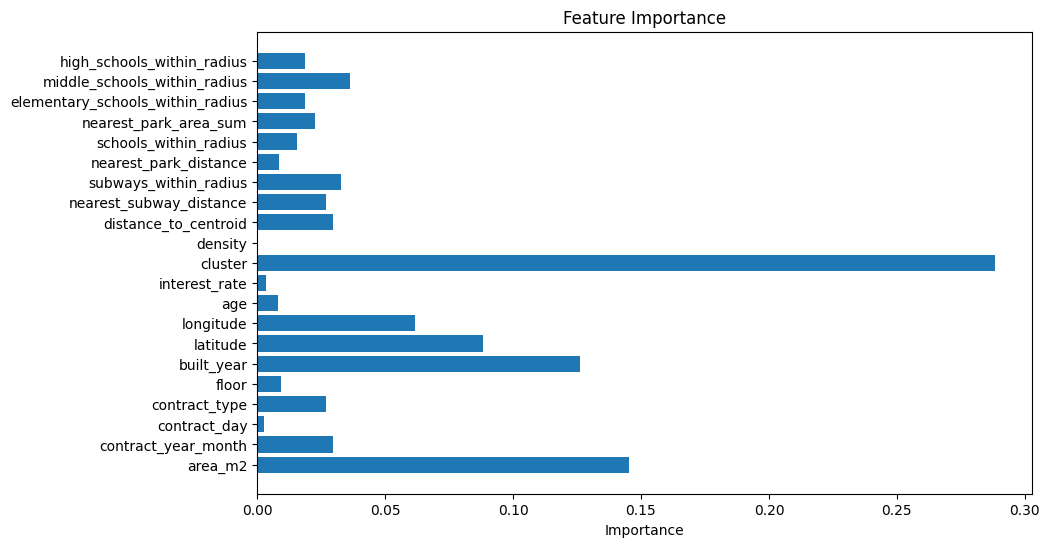

In [19]:
# 피처 중요도 얻기
importance = model.feature_importances_

# 피처 중요도 시각화
plt.figure(figsize=(10, 6))
plt.barh(X_train.columns, importance)
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.show()